This code uses the wulff_construction package from the Atomic Simulation Environment to generate nanoparticle structures. 

In [ ]:
from ase.io import write
from ase.cluster import wulff_construction
import time

The Wulff constructions are a single crystal structure based on optimizing the surface energy by changing the ratio of facetting present (100 vs 111 vs 110 for example). You can find input surface energies and nice Wulff structure visualizations here (http://crystalium.materialsvirtuallab.org/) 

As an input to this script you should input which facets you want to have, the respective surface energies, and the lattice constant of the material. 

In [ ]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
esurf = [0.0376, 0.0398, 0.0317] #units dont matter here because we take ratios 
lc = 4.153 #Angstroms 

Based on the surface energies input the generated "Magic numbers" may differ (the constructed shapes are not neccessarily self similar). The ASE wulff construction script takes an integer and outputs the closest stable magic number construction. This script will take a max_atoms argument and find all stable magic number constructions in that range. 

In [ ]:


magic_numbers = [] #initialize list
seen_atoms = set()
max_atoms = 9000 #max number of atoms to search for
size = 1 #starting size

with open("magic_numbers.txt", "w") as f:
    while True:
        start_time = time.time()

        atoms = wulff_construction('Au', surfaces, esurf, size, 'fcc',
                                   rounding='above', latticeconstant=lc)
        natoms = len(atoms)

        if natoms not in seen_atoms:
            seen_atoms.add(natoms)
            magic_numbers.append(natoms)
            f.write(f"{natoms}\n")
            print(f"Magic number found: {natoms} (input size={size})")

            # Save the structure
            write(f"magic_{natoms}.extxyz", atoms) #ASE write tool if you want you can change this to a different format

            if natoms >= max_atoms:
                print(f"Reached {natoms} atoms. Stopping.")
                break

            # Jump ahead just past current number of atoms to save time
            size = natoms + 1
        else:
            # Increment normally if no new magic number
            size += 1

        # Print progress occasionally
        if size % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Checked size {size}, atoms={natoms}, time={elapsed:.2f}s")

print(f"Done. Found {len(magic_numbers)} magic numbers up to {max_atoms} atoms.")


Magic number found: 1 (input size=1)
Magic number found: 13 (input size=2)
Magic number found: 19 (input size=14)
Magic number found: 43 (input size=20)
Magic number found: 55 (input size=44)
Magic number found: 79 (input size=56)
Magic number found: 135 (input size=80)
Magic number found: 165 (input size=136)
Magic number found: 201 (input size=166)
Magic number found: 225 (input size=202)
Magic number found: 369 (input size=226)
Magic number found: 405 (input size=370)
Magic number found: 459 (input size=406)
Magic number found: 675 (input size=460)
Magic number found: 711 (input size=676)
Magic number found: 807 (input size=712)
Magic number found: 861 (input size=808)
Magic number found: 1229 (input size=862)
Magic number found: 1289 (input size=1230)
Magic number found: 1385 (input size=1290)
Magic number found: 1865 (input size=1386)
Magic number found: 1925 (input size=1866)
Magic number found: 2075 (input size=1926)
Magic number found: 2675 (input size=2076)
Magic number found:

In [3]:
import matplotlib.pyplot as plt
from ase.io import read
from ase.visualize.plot import plot_atoms


In [5]:
import pyvista as pv
import numpy as np

/Users/acs/miniforge3/envs/home/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2386: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/acs/miniforge3/envs/home/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


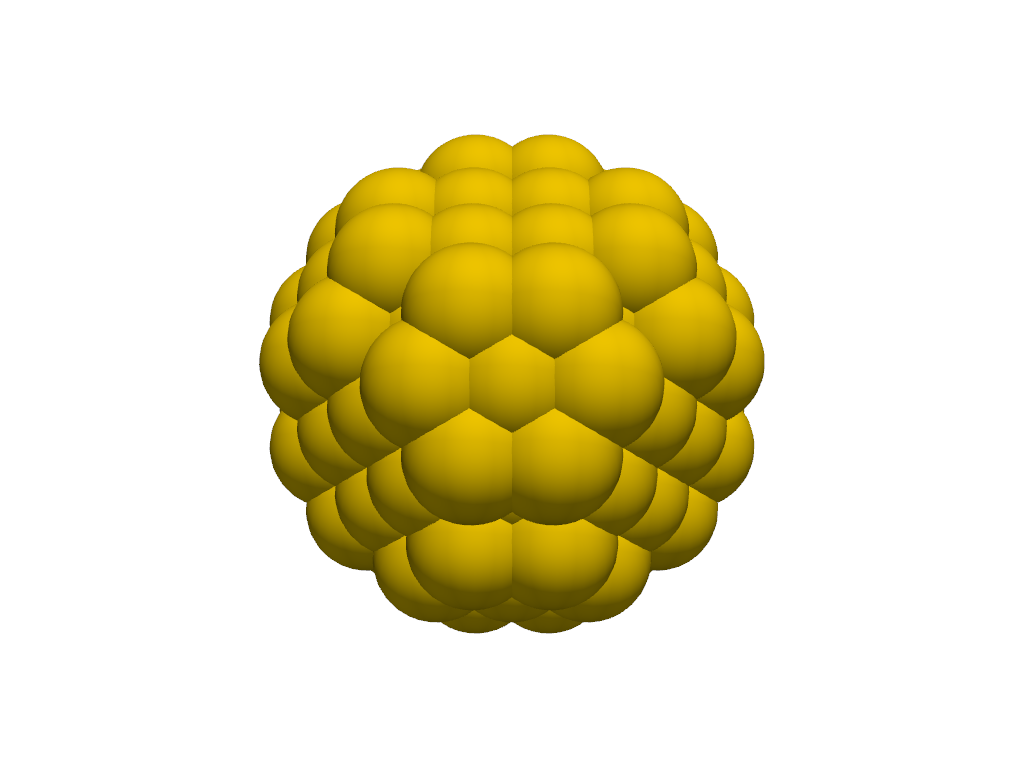

In [13]:


# === Load structure ===
magic_number = 135
atoms = read(f'magic_{magic_number}.extxyz')
positions_np = atoms.get_positions()

# === Create point cloud ===
point_cloud = pv.PolyData(positions_np)

# === Generate spheres ===
spheres = point_cloud.glyph(scale=False, geom=pv.Sphere(radius=2.5))

# === Set up plotter ===
plotter = pv.Plotter()
plotter.add_mesh(spheres, color='gold', smooth_shading=True)
plotter.show()




In [ ]:
# === Paths ===
input_dir = "AuNP"           # Folder containing .extxyz files
output_dir = "AuNPimages"    # Folder to save PNGs
os.makedirs(output_dir, exist_ok=True)

# === Loop through structures ===
for filename in sorted(os.listdir(input_dir)):
    if filename.startswith("magic_") and filename.endswith(".extxyz"):
        filepath = os.path.join(input_dir, filename)

        # Load atoms
        atoms = read(filepath)
        positions_np = atoms.get_positions()
        natoms = len(atoms)

        # Build spheres
        point_cloud = pv.PolyData(positions_np)
        spheres = point_cloud.glyph(scale=False, geom=pv.Sphere(radius=1.5))

        # Plotter
        plotter = pv.Plotter(off_screen=True, window_size=(800, 800))
        plotter.add_mesh(spheres, color='gold', smooth_shading=True)

        # Camera: zoom to fit and tighten view
        plotter.camera_position = 'xy'  # Nice angle
        plotter.camera.zoom(1.4)        # Zoom in to reduce whitespace

        # Add bold title text (larger font, closer to center)
        plotter.add_text(f"{natoms} atoms",
                         position='upper_edge',
                         font_size=24,
                         color='black',
                         shadow=True)

        # Save PNG
        output_path = os.path.join(output_dir, f"{filename.replace('.extxyz', '.png')}")
        plotter.show(screenshot=output_path)
        plotter.close()

        print(f"Saved: {output_path}")


In [19]:
import re

# === Config ===
input_dir = "AuNPimages"
output_file = "nanoparticles_grid_sorted.png"
thumb_size = (600, 600)
cols = 7

# === Extract numeric sort key from filename ===
def extract_number(fname):
    match = re.search(r"magic_(\d+)", fname)
    return int(match.group(1)) if match else float('inf')

# === Load and sort images ===
images = [f for f in os.listdir(input_dir) if f.endswith(".png")]
images = sorted(images, key=extract_number)
n_images = len(images)
rows = math.ceil(n_images / cols)

# === Create canvas ===
grid_width = cols * thumb_size[0]
grid_height = rows * thumb_size[1]
grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

# === Paste into grid ===
for idx, filename in enumerate(images):
    img_path = os.path.join(input_dir, filename)
    img = Image.open(img_path).resize(thumb_size, resample=Image.LANCZOS)
    x = (idx % cols) * thumb_size[0]
    y = (idx // cols) * thumb_size[1]
    grid_img.paste(img, (x, y))

# === Save final output ===
grid_img.save(output_file, dpi=(300, 300))
print(f"Saved final sorted grid: {output_file}")

Saved final sorted grid: nanoparticles_grid_sorted.png


In [23]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
esurf = [0.108, 0.113, 0.101] #units dont matter here because we take ratios
lc = 3.976 #Angstroms 

magic_numbers = []
seen_atoms = set()
max_atoms = 9000
size = 1

with open("magic_numbers.txt", "w") as f:
    while True:
        start_time = time.time()

        atoms = wulff_construction('Au', surfaces, esurf, size, 'fcc',
                                   rounding='above', latticeconstant=lc)
        natoms = len(atoms)

        if natoms not in seen_atoms:
            seen_atoms.add(natoms)
            magic_numbers.append(natoms)
            f.write(f"{natoms}\n")
            print(f"Magic number found: {natoms} (input size={size})")

            # Save the structure
            write(f"magic_{natoms}.extxyz", atoms)

            if natoms >= max_atoms:
                print(f"Reached {natoms} atoms. Stopping.")
                break

            # Jump ahead just past current number of atoms to save time
            size = natoms + 1
        else:
            # Increment normally if no new magic number
            size += 1

        # Print progress occasionally
        if size % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Checked size {size}, atoms={natoms}, time={elapsed:.2f}s")

print(f"Done. Found {len(magic_numbers)} magic numbers up to {max_atoms} atoms.")


Magic number found: 1 (input size=1)
Magic number found: 13 (input size=2)
Magic number found: 19 (input size=14)
Magic number found: 43 (input size=20)
Magic number found: 55 (input size=44)
Magic number found: 79 (input size=56)
Magic number found: 135 (input size=80)
Magic number found: 165 (input size=136)
Magic number found: 201 (input size=166)
Magic number found: 249 (input size=202)
Magic number found: 297 (input size=250)
Magic number found: 369 (input size=298)
Magic number found: 405 (input size=370)
Magic number found: 459 (input size=406)
Magic number found: 579 (input size=460)
Magic number found: 675 (input size=580)
Magic number found: 711 (input size=676)
Magic number found: 807 (input size=712)
Magic number found: 1007 (input size=808)
Magic number found: 1103 (input size=1008)
Magic number found: 1229 (input size=1104)
Magic number found: 1289 (input size=1230)
Magic number found: 1577 (input size=1290)
Magic number found: 1673 (input size=1578)
Magic number found: 1

In [ ]:
# === Paths ===
input_dir = "PtNP"           # Folder containing .extxyz files
output_dir = "PtNPimages"    # Folder to save PNGs
os.makedirs(output_dir, exist_ok=True)

# === Loop through structures ===
for filename in sorted(os.listdir(input_dir)):
    if filename.startswith("magic_") and filename.endswith(".extxyz"):
        filepath = os.path.join(input_dir, filename)

        # Load atoms
        atoms = read(filepath)
        positions_np = atoms.get_positions()
        natoms = len(atoms)

        # Build spheres
        point_cloud = pv.PolyData(positions_np)
        spheres = point_cloud.glyph(scale=False, geom=pv.Sphere(radius=1.5))

        # Plotter
        plotter = pv.Plotter(off_screen=True, window_size=(800, 800))
        plotter.add_mesh(spheres, color='silver', smooth_shading=True)

        # Camera: zoom to fit and tighten view
        plotter.camera_position = 'xy'  # Nice angle
        plotter.camera.zoom(1.4)        # Zoom in to reduce whitespace

        # Add bold title text (larger font, closer to center)
        plotter.add_text(f"{natoms} atoms",
                         position='upper_edge',
                         font_size=24,
                         color='black',
                         shadow=True)

        # Save PNG
        output_path = os.path.join(output_dir, f"{filename.replace('.extxyz', '.png')}")
        plotter.show(screenshot=output_path)
        plotter.close()

        print(f"Saved: {output_path}")


In [25]:
# === Config ===
input_dir = "PtNPimages"
output_file = "Ptnanoparticles_grid_sorted.png"
thumb_size = (600, 600)
cols = 7

# === Extract numeric sort key from filename ===
def extract_number(fname):
    match = re.search(r"magic_(\d+)", fname)
    return int(match.group(1)) if match else float('inf')

# === Load and sort images ===
images = [f for f in os.listdir(input_dir) if f.endswith(".png")]
images = sorted(images, key=extract_number)
n_images = len(images)
rows = math.ceil(n_images / cols)

# === Create canvas ===
grid_width = cols * thumb_size[0]
grid_height = rows * thumb_size[1]
grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

# === Paste into grid ===
for idx, filename in enumerate(images):
    img_path = os.path.join(input_dir, filename)
    img = Image.open(img_path).resize(thumb_size, resample=Image.LANCZOS)
    x = (idx % cols) * thumb_size[0]
    y = (idx // cols) * thumb_size[1]
    grid_img.paste(img, (x, y))

# === Save final output ===
grid_img.save(output_file, dpi=(300, 300))
print(f"Saved final sorted grid: {output_file}")

Saved final sorted grid: Ptnanoparticles_grid_sorted.png
